In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms.functional as TF

Shape of Image: (914, 1225)
Shape of Mask: (914, 1225)


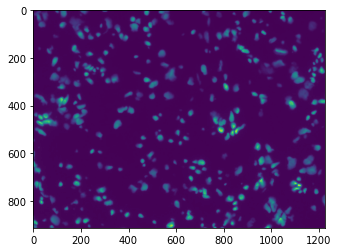

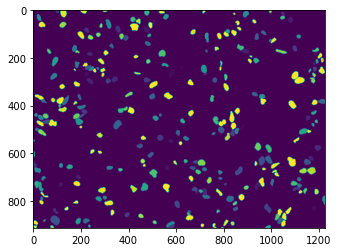

In [2]:
# visual check of train data

sample_image_np = cv2.imread('training_data/rawimages/Ganglioneuroblastoma_0.tif',0) # runtime error coz expected extension is 'TIFF' not 'TIF'
sample_image_pil = Image.fromarray(sample_image_np)
sample_mask_np = cv2.imread('training_data/groundtruth/Ganglioneuroblastoma_0.tif',-1) # something weird here, coz matlab tells me its uint16 with maxI = 300

alpha = sample_mask_np.max()/255 # Contrast control 
beta = 0 # Brightness control (0-100)
sample_mask_np = cv2.convertScaleAbs(sample_mask_np, alpha=alpha, beta=beta) # convert 0-255 range and to uint8

plt.figure()
plt.imshow(sample_image_np)

plt.figure()
plt.imshow(sample_mask_np)

# shape check
print('Shape of Image:', sample_image_np.shape)
print('Shape of Mask:', sample_mask_np.shape)

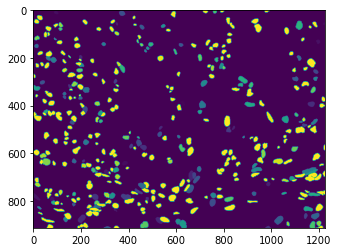

In [3]:
# functionize the conversion of uint16 + max intensiy correction (only for GTs)

def readCorrectLab(img_path):
    img = cv2.imread(img_path,-1)
    alpha = img.max()/255 # Contrast control 
    beta = 0 # Brightness control (0-100)
    properImg = cv2.convertScaleAbs(img, alpha=alpha, beta=beta) # convert 0-255 range and to uint8
    return properImg


# re-checking
plt.imshow(readCorrectLab('training_data/groundtruth/Ganglioneuroblastoma_1.tif'))

In [4]:
# create dataloader that returns - Image and Target pairs

class NucleiData(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "training_data/rawimages/"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "training_data/groundtruth/"))))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "training_data/rawimages/", self.imgs[idx])
        mask_path = os.path.join(self.root, "training_data/groundtruth/", self.masks[idx])
        img = Image.open(img_path).convert("RGB") # Pretrained MaskR-CNN uses RGB but if training from scratch we could use Gray
        mask = readCorrectLab(mask_path)
        
        obj_ids = np.unique(mask) # each unique nucleus = a new intensity value 
        obj_ids = obj_ids[1:] # because obj_ids[0] = background 
        masks = mask == obj_ids[:, None, None]
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64) # there is only one class i.e. the nuclei
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # if all instances are not nuclei
        isnuclei = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["isnuclei"] = isnuclei
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = NucleiData('./', get_transform(train=True))
dataset_test = NucleiData('./', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-15])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-15:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, 
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, 
    collate_fn=utils.collate_fn)

In [7]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device = torch.device('cpu')
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    if (epoch%2==0):
        torch.save(model, 'trained_model/mask-rcnn-nuclei-epoch-{}.pth'.format(epoch))
    


Epoch: [0]  [ 0/32]  eta: 0:22:01  lr: 0.000166  loss: 3.5101 (3.5101)  loss_classifier: 0.6062 (0.6062)  loss_box_reg: 0.3320 (0.3320)  loss_mask: 0.7414 (0.7414)  loss_objectness: 1.5748 (1.5748)  loss_rpn_box_reg: 0.2558 (0.2558)  time: 41.2839  data: 1.6637  max mem: 0
